### Introduction

This notebook is an analysis of the Crowdflower labels of 1000 random revisions of Wikipedia talk pages. This dataset has been cleaned and filtered to remove common administrator messages. These datasets are annotated via crowdflower to measure friendliness, aggressiveness and whether the comment constitutes a personal attack. 

On Crowdflower, each revision is rated 7 times. The raters are given two questions:

1. How aggressive or friendly is the tone of this comment?
    * Ranges from ‘Very Aggressive’ (2) to ‘Very Friendly’ (-2)
    * Includes an ‘N/A’ value for comments that aren’t in English or human-readable.
2. Is this an example of harassment or a personal attack?
    * Values are ‘Yes’ (1), ‘No’ (0), and ‘N/A’ (‘N/A’)


Below, we plot histograms of the units by average rating of each of the questions, examine quantiles of answers, and compute inter-annotator agreement.

### Loading packages and data

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Download data from google drive (Respect Eng / Wiki Collab): wikipdia data/v0_annotated
dat = pd.read_csv('../data/experiment-0.csv')

In [4]:
# Remove test questions
dat = dat[dat['_golden'] == False]

In [7]:
dat['num_aggressive_na'] = np.isnan(dat['how_aggressive_or_friendly'])
dat['num_attack_na'] = np.isnan(dat['is_harassment_or_attack'])

In [8]:
def create_column_of_counts_from_nums(df, col):
    return df.apply(lambda x: int(col) == x)

In [9]:
aggressive_columns = ['-2', '-1', '0', '1', '2']

In [10]:
for col in aggressive_columns:
    dat[col] = create_column_of_counts_from_nums(dat['how_aggressive_or_friendly'], col)

In [11]:
dat['not_attack_1'] = 1 - dat['is_harassment_or_attack']
dat['not_attack_0'] = dat['is_harassment_or_attack']

In [12]:
# Group the data
agg_dict = dict.fromkeys(aggressive_columns, 'sum')
agg_dict.update({'clean_diff': 'first', 'num_aggressive_na': 'sum', 'num_attack_na': 'sum',
                 '_id':'count', 'not_attack_0':'sum', 'not_attack_1': 'sum'})
grouped_dat = dat.groupby(['rev_id'], as_index=False).agg(agg_dict)

In [13]:
# Get rid of data which the majority thinks is not in English or not readable
grouped_dat = grouped_dat[(grouped_dat['num_aggressive_na'] <= grouped_dat['_id']/2) & (grouped_dat['num_attack_na'] <= grouped_dat['_id']/2)]

In [14]:
def compute_aggression_score(x, cols):
    n = 0
    s = 0
    for col in cols:
        s = s + x[col]*int(col)
        n = n + x[col]
    return s/n

In [15]:
grouped_dat['aggression_score'] = grouped_dat[aggressive_columns].dot([-2,-1,0,1,2])/grouped_dat['_id']

In [16]:
grouped_dat['attack_score'] = grouped_dat['not_attack_0']/grouped_dat['_id']

### Plot histogram of average ratings by revision

For each revision, we take the average of all the ratings by level of friendliness/aggressiveness and for each of the answers to Question 3. The histograms of these averages is displayed below.

In [17]:
def hist_comments(df, bins, plot_by, title):
    plt.figure()
    sliced_array = df[[plot_by]]
    weights = np.ones_like(sliced_array)/len(sliced_array)
    sliced_array.plot.hist(bins = bins, legend = False, title = title, weights=weights)
    plt.ylabel('Proportion')
    plt.xlabel('Average Score')

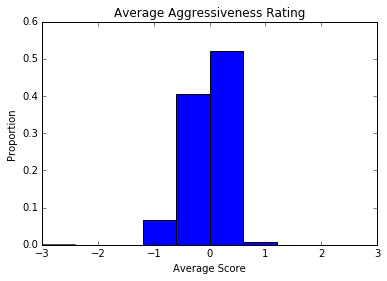

In [35]:
bins = np.linspace(-3,3,11)
hist_comments(grouped_dat, bins, 'aggression_score', 'Average Aggressiveness Rating')

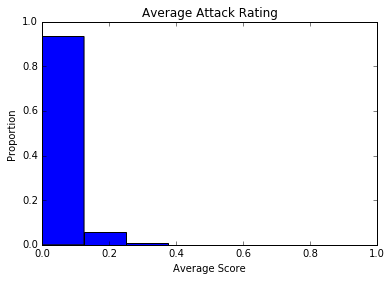

In [37]:
bins = np.linspace(0,1,9)
for col in ['attack_score']:
    hist_comments(grouped_dat, bins, col, 'Average Attack Rating')

### Selected harassing and aggressive revisions by quartile

We look at a sample of revisions whose average aggressive score falls into various quantiles. This allows us to subjectively evaluate the quality of the questions that we are asking on Crowdflower.

In [22]:
def sorted_comments(df, sort_by, quartile, num, is_ascending = True):
    n = df.shape[0]
    start_index = int(quartile*n)
    return df[['clean_diff', 'aggression_score', 'attack_score']].sort_values(
        by=sort_by, ascending = is_ascending)[start_index:start_index + num]

In [23]:
# Least aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0, 5)

,clean_diff,aggression_score,attack_score
877,"Thanks so much for your friendly welcome User:WillKomen. I can't wait to start editing! Ciaoyen (talk) 17:30, 15 October 2015 (UTC)",-1.142857,0
500,"Welcome!\n\nHello, Sameer yousef khan, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Unfortunately, one or more of your edits to the page :Rohit Shetty have not conformed to Wikipedia's verifiability policy, and may be removed if they have not yet been. Wikipedia articles should refer only to facts and interpretations that have been stated in print or on reputable websites or other forms of media. Always remember to provide a reliable source for quotations and for any material that is likely to be challenged, or it may be removed. Wikipedia also has a related policy against including original research in articles. Additionally, all new biographies of living people must contain at least one reliable source.\n\nIf you are stuck and looking for help, please see the guide for citing sources or come to the new contributors' help page, where experienced Wikipedians can answer any queries you have! Here are a few other good links...",-1.142857,0
290,"Barnstar of Awesome\n 300px|link= Barnstar of Awesome You are hereby awarded the Barnstar of Awesome for your amazing work adding published reliable sources, neutral and relevant information, clear formatting and beautiful images to the Wikipedia Adventure article on Earth. Keep up the stellar job you're doing. Yay you!\n--GaiaGirl86 (talk)",-1.142857,0
50,"Thanks so much for your friendly welcome User:WillKomen. I can't wait to start editing! Quincy101 (talk) 22:21, 30 March 2014 (UTC)",-1.142857,0
316,"Welcome! \n\nHello, Thomasabardin, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Unfortunately, one or more of the pages you created, such as Castle Key, may not conform to some of Wikipedia's guidelines, and may not be retained. \n\nThere's a page about creating articles you may want to read called Your first article. If you are stuck, and looking for help, please come to the Teahouse, where experienced Wikipedians can answer any queries you have! Or, you can just type on this page, followed by your question, and someone will show up shortly to answer your questions. Here are a few other good links for newcomers:\n Starting an article\n Your first article\n Contributing to Wikipedia\n Biographies of living persons\n How to write a great article\n The five pillars of Wikipedia\n Help pages\n Tutorial\nI hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this ...",-1.000000,0


In [24]:
# Median aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0.5, 5)

,clean_diff,aggression_score,attack_score
849,"25px|alt=Information icon Hello, I'm Materialscientist. I noticed that you made an edit concerning content related to a living (or recently deceased) person, but you didn't support your changes with a citation to a reliable source, so I removed it. Wikipedia has a very strict policy concerning how we write about living people, so please help us keep such articles accurate and clear. If you think I made a mistake, or if you have any questions, you can leave me a message on my talk page. Thank you! Materialscientist (talk) 03:39, 3 October 2015 (UTC)",0,0
850,"You should open an SPI if you suspect socking. And it's probably in your best interest to provide edit summaries and/or a note on the talk page lest an admin who's not paying attention decides it's a standard edit war and blocks you both. --NeilN talk to me 04:09, 3 October 2015 (UTC)",0,0
819,"Not if you can't demonstrate with reliable and neutral sources that they actually exist. George Custer's Sabre (talk) 17:47, 10 September 2015 (UTC)",0,0
650,"Oh! Iam so sorry, Its here Ekta Kaul's Biography]. --Roshan014Talk 15:59, 23 May 2015 (UTC)",0,0
654,"Speedy deletion nomination of :Mitchell (Mitch) Melvin Forte III\n48px|left|alt=|link=\n\nA tag has been placed on :Mitchell (Mitch) Melvin Forte III requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a person or group of people, but it does not indicate how or why the subject is important or significant: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, such articles may be deleted at any time. Please read more about what is generally accepted as notable. \n\nIf you think this page should not be deleted for this reason, you may contest the nomination by visiting the page and clicking the button labelled ""Click here to contest this speedy deletion"". This will give you the opportunity to explain why you believe the page should not be deleted. However, be aware that once a page is tagged for speedy...",0,0


In [25]:
# Most aggressive comments
sorted_comments(grouped_dat, 'aggression_score', 0, 5, False)

,clean_diff,aggression_score,attack_score
636,"im sick and tired of wikis bullshit, le tme live my life. this is americe bitch",1.142857,0.142857
627,"What are you doing?? \n\nThe info you added does. not. reference. a. source. That's bad, bad, bad! Does anyone know even where this freakin' came from???? --Taggy McTaggerstein (talk)",1.000000,0.285714
607,"That is bullshit. You can request the ""right to vanish"". Perhaps you should read your own EULA occasionally. Typical fascists.\nJusthereforthefun (talk) 19:51, 24 April 2015 (UTC)",1.000000,0.285714
763,Shut your mouth and stop talking. good boy,1.000000,0.714286
380,"non free image removal \n\nI see you dive-bombing the Graphics Workshop again removing non-free images leaving blank spots in your wake for others to fix or figure out. I would kindly ask that you don't be a dick and instead swap the offending image with {{GLNF|image.jpg}}. You might know the rules but often others don't. Being a dick about it isn't the most helpful way to go about fixing the problem. Of course one may say I'm trying to fix your problem by being a dick, but sometimes that's all someone being a dick understands. – JBarta (talk) 16:37, 10 November 2014 (UTC)",0.857143,0.428571


### Inter-Annotator Agreement

Below, we compute the Krippendorf's Alpha, which is a measure of the inter-annotator agreement of our Crowdflower responses. We achieve an Alpha value of 0.668 on our dataset, which is a relatively good level of inter-annotator agreement for this type of subjective inquiry.

In [26]:
def add_row_to_coincidence(o, row, columns):
    m_u = row.sum(1)
    for i in columns:
        for j in columns:
            if i == j:
                o[i][j] = o[i][j] + row[i]*(row[i]-1)/(m_u-1)
            else:
                o[i][j] = o[i][j] + row[i]*row[j]/(m_u-1)
    return o

In [27]:
def make_coincidence_matrix(df, columns):
    df = df[columns]
    n = df.shape[0]
    num_cols = len(columns)
    o = pd.DataFrame(np.zeros((num_cols,num_cols)), index = columns, columns=columns)
    for i in xrange(n):
        o = add_row_to_coincidence(o, df[i:i+1], columns)
    return o

In [28]:
def binary_distance(i,j):
    return i!=j

def interval_distance(i,j):
    return (int(i)-int(j))**2

In [29]:
def e(n, i, j):
    if i == j:
        return n[i]*(n[i]-1)/sum(n)-1
    else:
        return n[i]*n[j]/sum(n)-1

def D_e(o, columns, distance):
    n = o.sum(1)
    output = 0
    for i in columns:
        for j in columns:
            output = output + e(n,i,j)*distance(i,j)
    return output

def D_o(o, columns, distance):
    output = 0
    for i in columns:
        for j in columns:
            output = output + o[i][j]*distance(i,j)
    return output

In [30]:
def Krippendorf_alpha(df, columns, distance = binary_distance, o = None):
    if o is None:
        o = make_coincidence_matrix(df, columns)
    d_o = D_o(o, columns, distance)
    d_e = D_e(o, columns, distance)
    return (1 - d_o/d_e)

In [38]:
print "Krippendorf's Alpha (aggressiveness): "
Krippendorf_alpha(grouped_dat, aggressive_columns, distance = interval_distance)

Krippendorf's Alpha (aggressiveness): 


0.22295691536658335

In [39]:
print "Krippendorf's Alpha (attack): "
Krippendorf_alpha(grouped_dat, ['not_attack_0', 'not_attack_1'])

Krippendorf's Alpha (attack): 


0.062529240139161946